<a href="https://colab.research.google.com/github/eyadashrafkh/AlexEagles_mega_project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Object Detection Model training using YOLO
References -
- [Documentation](https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#13-prepare-dataset-for-yolov5)
- [Testing IoU](https://stackoverflow.com/questions/77565416/how-to-test-iou-score-after-training-a-yolo-model)
- [IoU calculation](https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation)
- [Hungarian Algorithm to match Bounding Boxes](https://gist.github.com/AruniRC/c629c2df0e68e23aff7dcaeef87c72d4)

In [1]:
!pip install ultralytics -q
!pip install fiftyone -q
# Import necessary libraries
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from ultralytics import YOLO
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
import json, shutil
from collections import defaultdict
from itertools import product
from functools import reduce
from scipy.optimize import linear_sum_assignment
import cv2

np.random.seed(0)
# Save to current directory
curr_dir = os.getcwd()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.1/903.1 kB 27.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.9/942.9 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.7 MB/s eta 0:00:0

In [2]:
# Load dataset
fo.config.dataset_zoo_dir = curr_dir

# Define the 15 classes you want to include
selected_classes = [
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "boat",
    "stop sign",
    "snowboard",
    "umbrella",
    "sports ball",
    "baseball bat",
    "bed",
    "tennis racket",
    "suitcase",
    "skis",
]

# Download the data
# By default, the following loads data for detections
dataset = foz.load_zoo_dataset("coco-2017",
                            splits=['train'],
                            shuffle=True,
                            seed=0,
                            max_samples=5000,
                            label_types=['detections'],
                            only_matching=True,
                            classes=selected_classes)

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/content/coco-2017/train' if necessary


INFO:fiftyone.utils.coco:Downloading annotations to '/content/coco-2017/tmp-download/annotations_trainval2017.zip'


 100% |██████|    1.9Gb/1.9Gb [6.1s elapsed, 0s remaining, 329.8Mb/s]       


INFO:eta.core.utils: 100% |██████|    1.9Gb/1.9Gb [6.1s elapsed, 0s remaining, 329.8Mb/s]       


Extracting annotations to '/content/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Extracting annotations to '/content/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Downloading 5000 images


 100% |████████████████| 5000/5000 [17.0m elapsed, 0s remaining, 4.7 images/s]      


INFO:eta.core.utils: 100% |████████████████| 5000/5000 [17.0m elapsed, 0s remaining, 4.7 images/s]      


Writing annotations for 5000 downloaded samples to '/content/coco-2017/train/labels.json'


INFO:fiftyone.utils.coco:Writing annotations for 5000 downloaded samples to '/content/coco-2017/train/labels.json'


Dataset info written to '/content/coco-2017/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/content/coco-2017/info.json'


Loading 'coco-2017' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'train'


 100% |███████████████| 5000/5000 [16.6s elapsed, 0s remaining, 329.5 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 5000/5000 [16.6s elapsed, 0s remaining, 329.5 samples/s]      


Dataset 'coco-2017-train-5000' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2017-train-5000' created


In [3]:
# Load the downloaded dataset
coco_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path='coco-2017/train/data',
    labels_path='coco-2017/train/labels.json',
    max_samples=5000,
    include_id=True,
)

 100% |███████████████| 5000/5000 [2.2m elapsed, 0s remaining, 41.8 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 5000/5000 [2.2m elapsed, 0s remaining, 41.8 samples/s]      


In [4]:
# The above downloads all classes in COCO
# We filter them to only have people using the following -
coco_dataset.export(
    labels_path="coco-2017/labels.json",
    dataset_type=fo.types.COCODetectionDataset,
    classes=selected_classes,
)

Found multiple fields ['detections', 'segmentations'] with compatible type (<class 'fiftyone.core.labels.Detections'>, <class 'fiftyone.core.labels.Polylines'>, <class 'fiftyone.core.labels.Keypoints'>); exporting 'detections'


INFO:fiftyone.core.collections:Found multiple fields ['detections', 'segmentations'] with compatible type (<class 'fiftyone.core.labels.Detections'>, <class 'fiftyone.core.labels.Polylines'>, <class 'fiftyone.core.labels.Keypoints'>); exporting 'detections'


   0% ||--------------|    0/5000 [33.2ms elapsed, ? remaining, ? samples/s] 

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'person' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'kite' not in provided classes
  warnings.warn(msg)


   0% |/--------------|    4/5000 [146.0ms elapsed, 3.0m remaining, 27.4 samples/s] 

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'handbag' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'tie' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'train' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'clock' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'parking meter' not in provided classes
  warnings.warn(msg)


   0% |---------------|    8/5000 [265.4ms elapsed, 2.8m remaining, 30.1 samples/s] 

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'bicycle' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'skateboard' not in provided classes
  warnings.warn(msg)


   0% |\--------------|   14/5000 [394.8ms elapsed, 2.3m remaining, 35.5 samples/s] 

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'book' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'elephant' not in provided classes
  warnings.warn(msg)


   0% ||--------------|   20/5000 [500.6ms elapsed, 2.1m remaining, 40.0 samples/s] 

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'cake' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'cup' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'cat' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'truck' not in provided classes
  warnings.warn(msg)


   1% |/--------------|   26/5000 [606.9ms elapsed, 1.9m remaining, 42.8 samples/s] 

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'banana' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'wine glass' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'hot dog' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'chair' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'dining table' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'sandwich' not in provided classes
  warnings.warn(msg)
/usr/local/lib/p

   1% ||--------------|   46/5000 [937.9ms elapsed, 1.7m remaining, 49.0 samples/s] 

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'bird' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'tv' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'bench' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'potted plant' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'teddy bear' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'backpack' not in provided classes
  warnings.warn(msg)


   1% |\--------------|   59/5000 [1.3s elapsed, 1.8m remaining, 50.8 samples/s]    

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'laptop' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'fire hydrant' not in provided classes
  warnings.warn(msg)


   2% |---------------|   80/5000 [1.6s elapsed, 1.6m remaining, 55.8 samples/s]    

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'dog' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'cow' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'cell phone' not in provided classes
  warnings.warn(msg)


   2% |\--------------|  116/5000 [2.5s elapsed, 1.7m remaining, 48.5 samples/s]    

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'bottle' not in provided classes
  warnings.warn(msg)


   3% ||--------------|  148/5000 [3.1s elapsed, 1.7m remaining, 42.2 samples/s]    

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'vase' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'microwave' not in provided classes
  warnings.warn(msg)


   3% |---------------|  155/5000 [3.3s elapsed, 1.7m remaining, 51.2 samples/s]    

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'keyboard' not in provided classes
  warnings.warn(msg)


   3% ||--------------|  170/5000 [3.5s elapsed, 1.7m remaining, 50.4 samples/s]    

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'apple' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'orange' not in provided classes
  warnings.warn(msg)


   4% |---------------|  181/5000 [3.8s elapsed, 1.7m remaining, 49.8 samples/s]    

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'frisbee' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'mouse' not in provided classes
  warnings.warn(msg)


   4% ||--------------|  221/5000 [4.5s elapsed, 1.6m remaining, 55.8 samples/s]    

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'refrigerator' not in provided classes
  warnings.warn(msg)


   5% |\--------------|  271/5000 [6.0s elapsed, 1.8m remaining, 40.1 samples/s]    

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'surfboard' not in provided classes
  warnings.warn(msg)


   6% ||--------------|  319/5000 [7.7s elapsed, 1.9m remaining, 31.0 samples/s]    

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'horse' not in provided classes
  warnings.warn(msg)


   7% |█/-------------|  341/5000 [8.8s elapsed, 2.2m remaining, 18.8 samples/s]    

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'bowl' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'pizza' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'remote' not in provided classes
  warnings.warn(msg)


   7% |█/-------------|  356/5000 [9.3s elapsed, 2.1m remaining, 25.2 samples/s]    

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'couch' not in provided classes
  warnings.warn(msg)


   7% |█\-------------|  365/5000 [9.6s elapsed, 2.1m remaining, 31.4 samples/s]    

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'bear' not in provided classes
  warnings.warn(msg)


   8% |█|-------------|  420/5000 [11.1s elapsed, 2.0m remaining, 38.3 samples/s]   

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'fork' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'knife' not in provided classes
  warnings.warn(msg)


  10% |█\-------------|  481/5000 [12.3s elapsed, 1.9m remaining, 47.4 samples/s]   

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'sheep' not in provided classes
  warnings.warn(msg)


  11% |█\-------------|  550/5000 [13.7s elapsed, 1.8m remaining, 50.0 samples/s]   

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'zebra' not in provided classes
  warnings.warn(msg)


  11% |█\-------------|  568/5000 [14.1s elapsed, 1.8m remaining, 47.9 samples/s]   

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'spoon' not in provided classes
  warnings.warn(msg)


  16% |██-------------|  791/5000 [19.0s elapsed, 1.6m remaining, 50.8 samples/s]   

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'oven' not in provided classes
  warnings.warn(msg)


  17% |██|------------|  827/5000 [19.7s elapsed, 1.6m remaining, 53.3 samples/s]   

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'sink' not in provided classes
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'toilet' not in provided classes
  warnings.warn(msg)


  21% |███|-----------| 1052/5000 [26.1s elapsed, 1.6m remaining, 39.6 samples/s]   

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'giraffe' not in provided classes
  warnings.warn(msg)


  29% |████|----------| 1470/5000 [34.2s elapsed, 1.3m remaining, 56.4 samples/s]   

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'broccoli' not in provided classes
  warnings.warn(msg)


  31% |████\----------| 1544/5000 [35.5s elapsed, 1.2m remaining, 57.5 samples/s]   

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'hair drier' not in provided classes
  warnings.warn(msg)


  31% |████-----------| 1561/5000 [35.8s elapsed, 1.3m remaining, 51.5 samples/s]   

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'scissors' not in provided classes
  warnings.warn(msg)


  33% |████/----------| 1638/5000 [38.1s elapsed, 1.5m remaining, 31.2 samples/s]   

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'carrot' not in provided classes
  warnings.warn(msg)


  44% |██████/--------| 2220/5000 [50.2s elapsed, 58.8s remaining, 51.8 samples/s]  

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'toothbrush' not in provided classes
  warnings.warn(msg)


  91% |█████████████/-| 4570/5000 [1.7m elapsed, 7.8s remaining, 56.6 samples/s]    

/usr/local/lib/python3.10/dist-packages/fiftyone/utils/coco.py:890: UserWarning: Ignoring object with label 'toaster' not in provided classes
  warnings.warn(msg)


 100% |███████████████| 5000/5000 [1.9m elapsed, 0s remaining, 45.7 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 5000/5000 [1.9m elapsed, 0s remaining, 45.7 samples/s]      


In [5]:
# We need to convert the dataset to YOLO format
input_dir = curr_dir + "/coco-2017/"
output_dir = curr_dir + "/yolo/"

images_folder = input_dir + "train/data/"


if not os.path.exists(output_dir):
	os.mkdir(output_dir)

for split in ['train', 'test']:
	shutil.rmtree(output_dir + split, ignore_errors=True)
	os.mkdir(output_dir + split)
	os.mkdir(output_dir + split + '/images')
	os.mkdir(output_dir + split + '/labels')

In [6]:

ground_truths = defaultdict(list)

# Read the annotations
with open(input_dir + 'labels.json', 'r') as f:
		data = json.load(f)

# Count number of annotations
num_data = len(data['images'])
print(f"Total number of images are {num_data}")

# Choose 80-20 split
num_train = np.floor(0.8*num_data)
num_test = np.floor(0.2*num_data)
print(num_train, num_test)

# Match annotations to images and write in YOLO format
count = 0

id_ann = defaultdict(list)
for ann in data['annotations']:
	id_ann[ann['image_id']].append(ann)

for image in data['images']:
	width = image['width']
	height = image['height']
	filename = image['file_name'].split('.')[0]
	id = image['id']


	# Writing current object and copying image
	if count < num_train:
		split = 'train'
	else:
		split = 'test'

	f = open(f'{output_dir}{split}/labels/{filename}.txt', 'w')

	for annotation in id_ann[id]:
		current_category = annotation['category_id'] - 1
		x, y, w, h = annotation['bbox']

		# Finding midpoints
		x_centre = x + w/2
		y_centre = y + h/2

		# Normalization
		x_centre /= width
		y_centre /= height
		w /= width
		h /= height

		# Limiting upto fix number of decimal places
		sx_centre = format(x_centre, '.6f')
		sy_centre = format(y_centre, '.6f')
		sw = format(w, '.6f')
		sh = format(h, '.6f')


		ground_truths[image['file_name']].append([x_centre, y_centre, w, h])

		f.write(f"{current_category} {sx_centre} {sy_centre} {sw} {sh}\n")
	f.close()
	shutil.copy(images_folder + image['file_name'], f'{output_dir}{split}/images/{filename}.jpg')
	count += 1

Total number of images are 5000
4000.0 1000.0


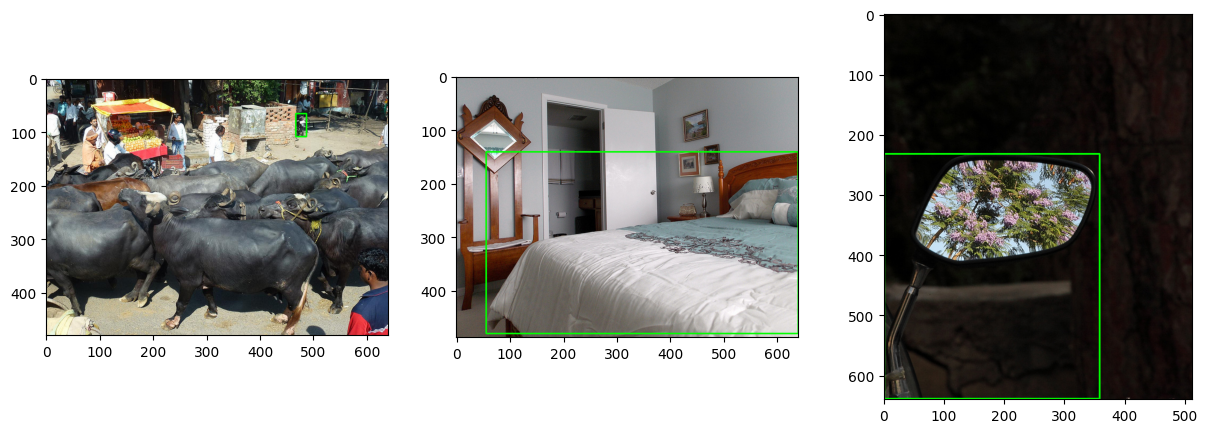

In [7]:
# Sample an image from the dataset for credibility
train_images = os.listdir(images_folder)
random_images = np.random.choice(train_images, 3)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, file in enumerate(random_images):
    img = cv2.imread(images_folder + file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    anns = ground_truths[file]
    for ann in anns:
        start = (int((ann[0] - ann[2]/2)*w), int((ann[1] - ann[3]/2)*h))
        end = (int((ann[0] + ann[2]/2)*w), int((ann[1] + ann[3]/2)*h))
        img = cv2.rectangle(img, start, end, (0, 255, 0), 2)
    ax[i].imshow(img)

In [ ]:
`# Load model for training
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 65.8MB/s]


In [ ]:
# Train the model
# Device = mps is for Apple Silicon
train_results = model.train(data='config.yaml', batch=16, epochs=10, plots=True, device='mps')

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=

100%|██████████| 755k/755k [00:00<00:00, 14.7MB/s]


Overriding model.yaml nc=80 with nc=14

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/yolo/train/labels... 4000 images, 1249 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:02<00:00, 1767.21it/s]

train: New cache created: /content/yolo/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/yolo/test/labels... 1000 images, 323 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<00:00, 1503.74it/s]

val: New cache created: /content/yolo/test/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000556, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/250 [00:11<?, ?it/s]


IndexError: index 14 is out of bounds for dimension 1 with size 14

In [ ]:
# Save the model
model.save(filename='trained.pt')

In [ ]:
# Load model from trained weights
model.load('trained.pt')

Transferred 427/427 items from pretrained weights


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_st

In [ ]:
def calc_iou(bb1, bb2):
    b1_x1 = bb1[0] - bb1[2]/2
    b1_x2 = bb1[0] + bb1[2]/2
    b1_y1 = bb1[1] - bb1[3]/2
    b1_y2 = bb1[1] + bb1[3]/2

    b2_x1 = bb2[0] - bb2[2]/2
    b2_x2 = bb2[0] + bb2[2]/2
    b2_y1 = bb2[1] - bb2[3]/2
    b2_y2 = bb2[1] + bb2[3]/2

    # determine the coordinates of the intersection rectangle
    x_left = max(b1_x1, b2_x1)
    y_top = max(b1_y1, b2_y1)
    x_right = min(b1_x2, b2_x2)
    y_bottom = min(b1_y2, b2_y2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = bb1[2]*bb1[3]
    bb2_area = bb2[2]*bb2[3]

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
# Test the data with IOU score
test_images_folder = output_dir + 'test/images/'
test_labels_folder = output_dir + 'test/labels'
test_files = os.listdir(test_images_folder)
sum_iou = 0
ious = defaultdict(float)
num_test = len(test_files)

# Create a folder to save the results
results_folder = output_dir + 'results/'
if not os.path.exists(results_folder):
	os.mkdir(results_folder)

# Iterate through the test files to test the performance
for test_file in test_files:
    res = model.predict(test_images_folder + test_file, classes=[0])
    res[0].save(results_folder + test_file)

    gt = ground_truths[test_file]
    preds = res[0].boxes.xywhn.numpy()

    if len(gt) == 0 or len(preds) == 0:
         continue

    combinations = list(product(gt, preds))
    iou_matrix = np.zeros((len(gt), len(preds)))
    for i in range(len(gt)):
        for j in range(len(preds)):
            iou_matrix[i, j] = calc_iou(gt[i], preds[j])

    # Do the Hungarian matching algorithm
    gt_idx, pred_idx = linear_sum_assignment(1 - iou_matrix)
    assigned_ious = np.sort(iou_matrix[gt_idx, pred_idx])[-len(gt):]

    # Compute mean across all instances in the image
    mean_iou = np.mean(assigned_ious)

    assert mean_iou <= 1.0

    sum_iou += mean_iou
    ious[test_file] = (mean_iou, assigned_ious)

In [ ]:
# Calculate the mean across all test cases
print("The average IoU across all test instances is", sum_iou/num_test)

The average IoU across all test instances is 0.7619198520725794



image 1/1 /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/test/images/000000531894.jpg: 448x640 4 persons, 56.0ms
Speed: 1.9ms preprocess, 56.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/test/images/000000520430.jpg: 544x640 1 person, 63.5ms
Speed: 1.2ms preprocess, 63.5ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/test/images/000000519706.jpg: 640x480 1 person, 65.6ms
Speed: 1.2ms preprocess, 65.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/test/images/000000465404.jpg: 480x640 11 persons, 63.2ms
Speed: 1.1ms preprocess, 63.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /Users/sud

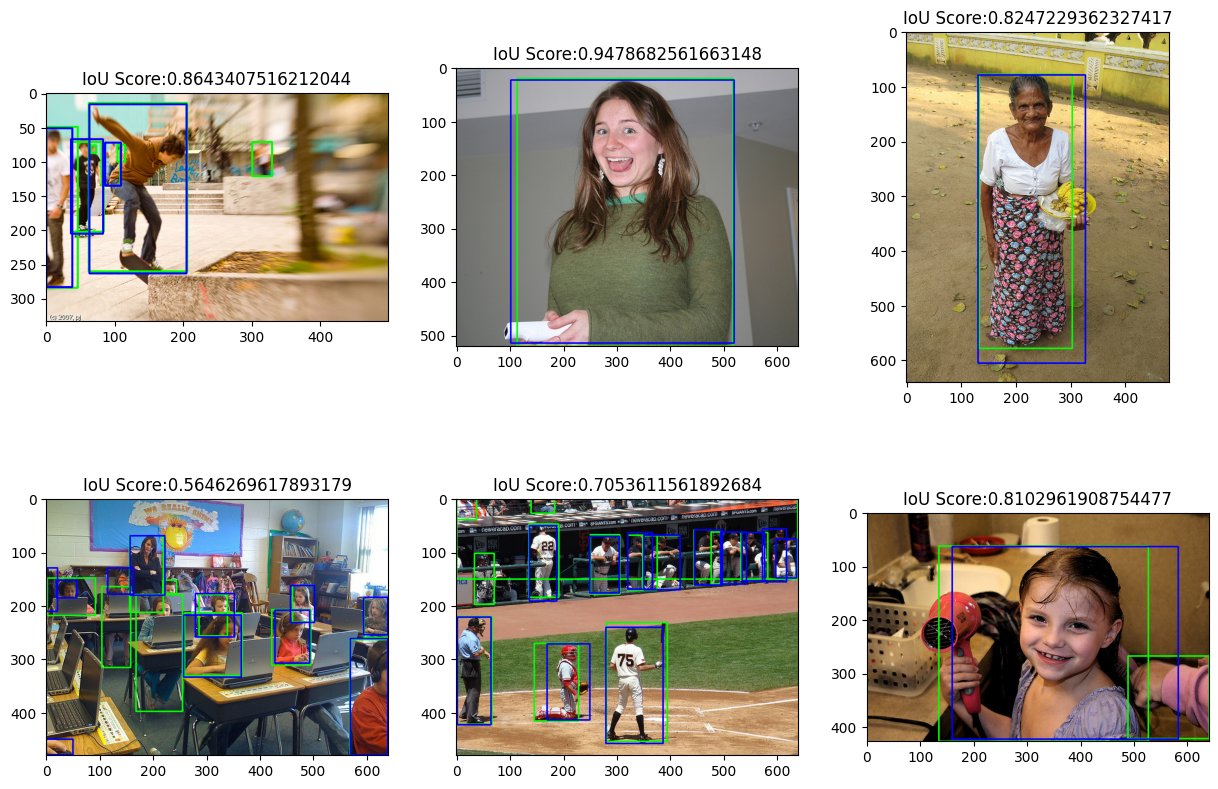

In [ ]:
# Show some sample output results
n_samples = 6
random_tests = np.random.choice(test_files, n_samples)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for t, test_file in enumerate(random_tests):
    res = model.predict(test_images_folder + test_file, classes=[0])
    preds = res[0].boxes.xywhn.numpy()
    img = cv2.imread(test_images_folder + test_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    gt = ground_truths[test_file]

    for ann in gt:
        start = (int((ann[0] - ann[2]/2)*w), int((ann[1] - ann[3]/2)*h))
        end = (int((ann[0] + ann[2]/2)*w), int((ann[1] + ann[3]/2)*h))
        img = cv2.rectangle(img, start, end, (0, 255, 0), 2)

    for ann in preds:
        start = (int((ann[0] - ann[2]/2)*w), int((ann[1] - ann[3]/2)*h))
        end = (int((ann[0] + ann[2]/2)*w), int((ann[1] + ann[3]/2)*h))
        img = cv2.rectangle(img, start, end, (0, 0, 255), 2)

    combinations = list(product(gt, preds))
    iou_matrix = np.zeros((len(gt), len(preds)))
    for i in range(len(gt)):
        for j in range(len(preds)):
            iou_matrix[i, j] = calc_iou(gt[i], preds[j])

    # Do the Hungarian matching algorithm
    gt_idx, pred_idx = linear_sum_assignment(1 - iou_matrix)
    assigned_ious = np.sort(iou_matrix[gt_idx, pred_idx])[-len(gt):]

    # Compute mean across all instances in the image
    mean_iou = np.mean(assigned_ious)

    ax[t // 3][t % 3].imshow(img)
    if mean_iou > 1:
        mean_iou = 0
    ax[t // 3][t % 3].set_title("IoU Score:" + str(mean_iou))